In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
print("Using GPU:", tf.config.list_physical_devices('GPU'))

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Importing necessary libraries from TensorFlow and others
from tensorflow.keras.applications import MobileNetV2  # Pretrained MobileNetV2 model
from tensorflow.keras.models import Sequential         # Sequential model structure
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D  # Various layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator          # For image preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau      # Callbacks for training
import os

In [4]:
# Setting up the training data path
train_path = '/content/drive/Shareddrives/capstone/capstone_ml/datasets2/train'


In [5]:
# Image dimensions and batch size configuration
img_width, img_height = 224, 224
batch_size = 32


In [6]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,                   # Normalize pixel values to [0, 1]
    validation_split=0.2,             # 20% of data for validation
    rotation_range=40,                # Random rotations
    width_shift_range=0.2,            # Horizontal shifts
    height_shift_range=0.2,           # Vertical shifts
    shear_range=0.2,                  # Shear transformations
    zoom_range=0.2,                   # Zoom-in and zoom-out
    vertical_flip=True,               # Flip images vertically
    horizontal_flip=True,             # Flip images horizontally
    brightness_range=[0.8, 1.2],      # Adjust brightness
    fill_mode='nearest',              # Fill missing pixels after transformations
)

# Preprocessing for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,                   # Normalize pixel values to [0, 1]
    validation_split=0.2              # 20% of data for validation
)

# Generating batches of augmented training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),  # Resize images to target dimensions
    batch_size=batch_size,
    class_mode='categorical',             # Multi-class classification
    subset='training'                     # Use training subset
)

# Generating batches of validation data
validation_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),  # Resize images to target dimensions
    batch_size=batch_size,
    class_mode='categorical',             # Multi-class classification
    subset='validation'                   # Use validation subset
)


Found 672 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


In [7]:
# Load the MobileNetV2 base model without the top layer
base_model = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model weights


In [8]:
# Building the full model using Sequential API
model = Sequential([
    base_model,                          # Add the base model
    GlobalAveragePooling2D(),            # Reduce feature dimensions
    Dense(128, activation='relu'),       # Fully connected layer with ReLU activation
    Dropout(0.5),                        # Dropout for regularization
    Dense(6, activation='softmax')       # Output layer for 6 classes
])


In [9]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()  # Print the model summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Callbacks to monitor and adjust training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Stop early to avoid overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)     # Reduce learning rate when stuck


In [11]:
# Train the model with training and validation data
history = model.fit(
    train_generator,
    epochs=20,                           # Set the maximum number of epochs
    validation_data=validation_generator,  # Use validation data
    callbacks=[early_stopping, reduce_lr]  # Apply callbacks during training
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2606 - loss: 2.0762 - val_accuracy: 0.6726 - val_loss: 0.9740 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 617ms/step - accuracy: 0.6934 - loss: 0.9527 - val_accuracy: 0.7798 - val_loss: 0.7569 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 616ms/step - accuracy: 0.7122 - loss: 0.7927 - val_accuracy: 0.8095 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 555ms/step - accuracy: 0.7182 - loss: 0.7391 - val_accuracy: 0.7619 - val_loss: 0.7204 - learning_rate: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 626ms/step - accuracy: 0.8284 - loss: 0.5335 - val_accuracy: 0.7798 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 638ms/step - accuracy: 0.8481 - loss: 0.4606 - val_accuracy: 0.7798 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 550ms/step - accuracy: 0.8644 - loss: 0.4503 - val_acc

In [12]:
# Evaluate the model on the validation dataset
evaluation = model.evaluate(validation_generator)
print(f"Akurasi Validasi: {evaluation[1] * 100:.2f}%")  # Print validation accuracy


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.7912 - loss: 0.7129
Akurasi Validasi: 80.95%


In [14]:
# Save the trained model
model.save('/content/drive/Shareddrives/capstone/capstone_ml/ML-Report/model.h5')


In [15]:
# Import libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 917ms/step
Confusion Matrix:
[[2 5 8 2 5 6]
 [4 4 4 7 7 2]
 [7 4 6 5 3 3]
 [6 5 9 3 3 2]
 [7 1 5 4 4 7]
 [5 8 3 3 5 4]]


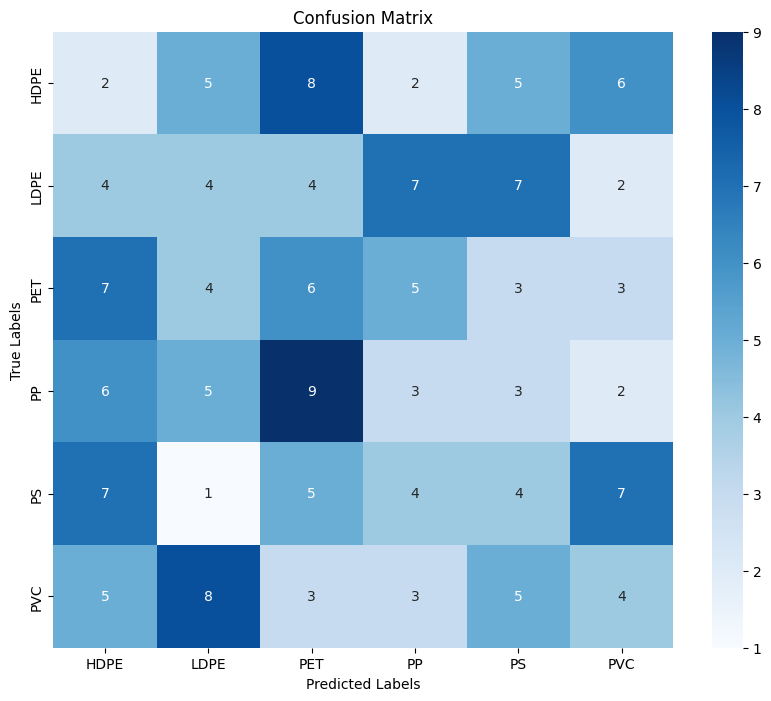

In [16]:
# Predict the validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert probabilities to class indices

# Get true labels for validation data
Y_true = validation_generator.classes

# Generate and display confusion matrix
cm = confusion_matrix(Y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [17]:

# Display classification report
print("\nClassification Report:")
print(classification_report(Y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))



Classification Report:
              precision    recall  f1-score   support

        HDPE       0.06      0.07      0.07        28
        LDPE       0.15      0.14      0.15        28
         PET       0.17      0.21      0.19        28
          PP       0.12      0.11      0.12        28
          PS       0.15      0.14      0.15        28
         PVC       0.17      0.14      0.15        28

    accuracy                           0.14       168
   macro avg       0.14      0.14      0.14       168
weighted avg       0.14      0.14      0.14       168



In [18]:
# Load and predict on a single image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model('/content/drive/Shareddrives/capstone/capstone_ml/CC/model5/model.h5')  # Load saved model

img_path = '/content/drive/Shareddrives/capstone/capstone_ml/MODEL/LDPE_0007.jpg'
img = image.load_img(img_path, target_size=(img_width, img_height))  # Load and resize image
img_array = image.img_to_array(img) / 255.0  # Normalize image array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

predictions = model.predict(img_array)  # Predict image class probabilities


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [19]:
# Print class probabilities
for i, prob in enumerate(predictions[0]):
    print(f"Class {i}: {prob*100:.2f}%")


Class 0: 0.08%
Class 1: 97.62%
Class 2: 0.19%
Class 3: 0.16%
Class 4: 0.19%
Class 5: 1.76%


In [20]:
# Save training history to a file
import pickle


In [21]:
history_path = '/content/drive/Shareddrives/capstone/capstone_ml/CC/model5/history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)  # Save history object
print(f"History has been saved at {history_path}")


History has been saved at /content/drive/Shareddrives/capstone/capstone_ml/CC/model5/history.pkl


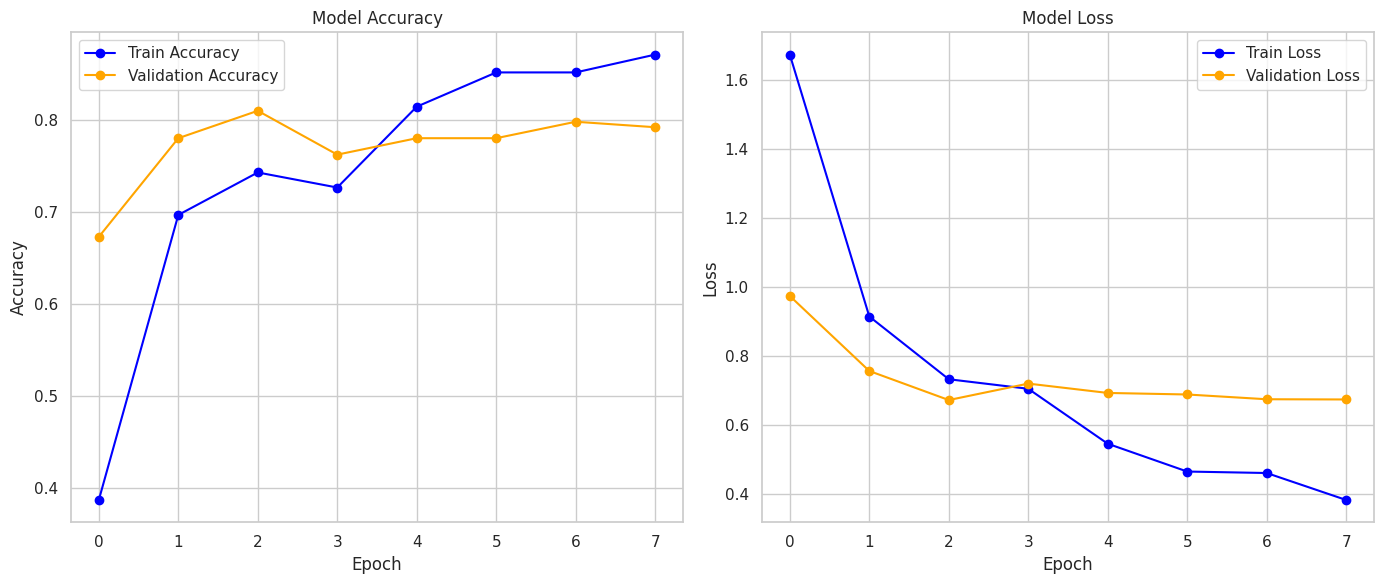

In [22]:
# Load and visualize training history
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

history_path = '/content/drive/Shareddrives/capstone/capstone_ml/CC/model5/history.pkl'
with open(history_path, 'rb') as f:
    history = pickle.load(f)  # Load history object

# Set visualization style
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy over epochs
ax[0].plot(history['accuracy'], label='Train Accuracy', marker='o', color='blue')
ax[0].plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss over epochs
ax[1].plot(history['loss'], label='Train Loss', marker='o', color='blue')
ax[1].plot(history['val_loss'], label='Validation Loss', marker='o', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

In [23]:
import csv

# Data untuk file CSV
data = [
    {"in": "Input1", "out": "Output1"},
    {"in": "Input2", "out": "Output2"},
    {"in": "Input3", "out": "Output3"},
    {"in": "Input4", "out": "Output4"}
]

# Nama file CSV
file_name = "in_out.csv"

# Membuat file CSV dan menuliskan data
with open(file_name, mode='w', newline='', encoding='utf-8') as file:
    # Menentukan kolom
    fieldnames = ['in', 'out']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Menulis header
    writer.writeheader()

    # Menulis data
    for row in data:
        writer.writerow(row)

print(f"File '{file_name}' berhasil dibuat dengan data in dan out!")


File 'in_out.csv' berhasil dibuat dengan data in dan out!
